In [1]:
import glob
train_files=glob.glob("meta_csv/train/anomaly/*")
test_files=glob.glob("./meta_csv/test/*.csv")
train_files,test_files

(['meta_csv/train/anomaly\\0.csv',
  'meta_csv/train/anomaly\\2.csv',
  'meta_csv/train/anomaly\\3.csv',
  'meta_csv/train/anomaly\\4.csv',
  'meta_csv/train/anomaly\\5.csv'],
 ['./meta_csv/test\\1.mp4.csv',
  './meta_csv/test\\2.mp4.csv',
  './meta_csv/test\\3.mp4.csv',
  './meta_csv/test\\4.mp4.csv',
  './meta_csv/test\\5.mp4.csv',
  './meta_csv/test\\6.mp4.csv'])

In [2]:
import pandas as pd
import numpy as np
df_train=pd.concat([pd.read_csv(pth) for pth in train_files])
df_test=pd.concat([pd.read_csv(pth) for pth in test_files])

In [3]:
df_train

,time_pos,byte_pos,size,type,is_normal,has_blur,has_move,has_overexposure,has_block
0,0.00,0.0,0.437067,I,1,0,0,0,0
1,0.04,113467.0,0.011355,P,1,0,0,0,0
2,0.08,116415.0,0.013570,P,1,0,0,0,0
3,0.12,119938.0,0.008848,P,1,0,0,0,0
4,0.16,122235.0,0.007916,P,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
7110,284.40,121137847.0,0.008536,B,1,0,0,0,0
7111,284.44,121116811.0,0.025591,P,1,0,0,0,0
7112,284.48,121152903.0,0.010604,B,1,0,0,0,0
7113,284.52,121158995.0,0.008489,B,1,0,0,0,0


In [4]:
df_test["is_anomaly"]=1-df_test["is_normal"]
df_train["is_anomaly"]=1-df_train["is_normal"]

In [5]:
df_train["is_anomaly"].mean()

0.24417924062179316

In [6]:
df_train["is_normal"].mean()

0.7558207593782068

In [7]:
df_train["is_anomaly"].isna().sum()

0

In [8]:
Xs_train,ys_train=[],[]
X_val,y_val=None,None
labels=["is_normal"]
features=["size","type"]
X_train,y_train=df_train[features],df_train[labels]
X_val,y_val=df_test[features],df_test[labels]


In [9]:
from imblearn.over_sampling import SMOTENC

step=25*60
Xs=[]
ys=[]
for i in range(0,X_train.shape[0]-step,step):
    smote=SMOTENC(categorical_features=[1])
    if(len(np.unique(y_train[i:i+step].values))==1):
        continue
    X_take,y_take=smote.fit_resample(X_train[i:i+step],y_train[i:i+step])
    Xs.append(X_take)
    ys.append(y_take)
    

C:\ml\my_env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\ml\my_env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [10]:
len(Xs)

70

In [11]:
X_train,y_train=pd.concat(Xs,axis=0),pd.concat(ys,axis=0)
X_train

,size,type
0,0.437067,I
1,0.011355,P
2,0.013570,P
3,0.008848,P
4,0.007916,P
...,...,...
2443,0.003953,B
2444,0.037687,P
2445,0.025045,B
2446,0.034610,P


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

In [13]:
pipeline=ColumnTransformer([
    ("num",StandardScaler(),["size"]),
    ("cat",OneHotEncoder(),["type"])])

In [38]:
#pipeline
timesteps=25*60
X_train_rdy=pipeline.fit_transform(X_train)
X_val_rdy=pipeline.transform(X_val)
def reshape_for_timsteps(data,timesteps):
    data_take=data[:data.shape[0]//timesteps*timesteps]
    return data_take.reshape(-1,timesteps,data_take.shape[1])

In [39]:
#reshaping
X_train_reshape=reshape_for_timsteps(X_train_rdy,timesteps)
y_train_reshape=reshape_for_timsteps(y_train.values,timesteps)
X_val_reshape=reshape_for_timsteps(X_val_rdy,timesteps)
y_val_reshape=reshape_for_timsteps(y_val.values,timesteps)


In [40]:
X_train.type.value_counts()

type
P    95989
B    71668
I      831
Name: count, dtype: int64

In [41]:
X_train_rdy.shape

(168488, 4)

In [42]:
X_train_reshape.shape,y_train_reshape.shape

((112, 1500, 4), (112, 1500, 1))

In [43]:
X_val_reshape.shape,y_val_reshape.shape

((37, 1500, 4), (37, 1500, 1))

In [44]:
X_train_reshape.shape

(112, 1500, 4)

In [114]:
from tensorflow import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense,Dropout,SimpleRNN,GRU, Bidirectional,LSTM
model = keras.models.Sequential()
model.add(Bidirectional(LSTM(32,activation="tanh",return_sequences=True),input_shape=(None, X_train_reshape.shape[2])))
model.add(Bidirectional(LSTM(64,activation="tanh",return_sequences=True),input_shape=(None, X_train_reshape.shape[2])))
model.add(Bidirectional(LSTM(128,activation="tanh",return_sequences=True),input_shape=(None, X_train_reshape.shape[2])))
model.add(Bidirectional(LSTM(64,activation="tanh",return_sequences=True),input_shape=(None, X_train_reshape.shape[2])))
model.add(Bidirectional(LSTM(32,activation="tanh",return_sequences=True),input_shape=(None, X_train_reshape.shape[2])))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=["accuracy",keras.metrics.AUC()])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_24 (Bidirect  (None, None, 64)          9472      
 ional)                                                          
                                                                 
 bidirectional_25 (Bidirect  (None, None, 128)         66048     
 ional)                                                          
                                                                 
 bidirectional_26 (Bidirect  (None, None, 256)         263168    
 ional)                                                          
                                                                 
 bidirectional_27 (Bidirect  (None, None, 128)         164352    
 ional)                                                          
                                                                 
 bidirectional_28 (Bidirect  (None, None, 64)         

In [115]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [116]:
from sklearn.utils import class_weight
class_weight = {}
for i in range(1):
    class_weight[i]=[(1-y_train.iloc[:,i].mean())*100,y_train.iloc[:,i].mean()*100]
class_weight={0:60,1:40}

In [117]:
X_train_reshape.shape

(112, 1500, 4)

In [118]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train_reshape,y_train_reshape,
              validation_data=(X_val_reshape,y_val_reshape),class_weight=class_weight,shuffle=False,batch_size=32,epochs=30,callbacks=[early_stopping,LearningRateScheduler(lr_scheduler)])

Epoch 1/30
4/4 [==============================] - 26s 5s/step - loss: 33.5365 - accuracy: 0.5060 - auc_13: 0.5544 - val_loss: 0.7424 - val_accuracy: 0.2290 - val_auc_13: 0.6155 - lr: 0.0010
Epoch 2/30
4/4 [==============================] - 16s 4s/step - loss: 31.2057 - accuracy: 0.5712 - auc_13: 0.6805 - val_loss: 0.6389 - val_accuracy: 0.7270 - val_auc_13: 0.6562 - lr: 8.5000e-04
Epoch 3/30
4/4 [==============================] - 16s 4s/step - loss: 31.0080 - accuracy: 0.5923 - auc_13: 0.6676 - val_loss: 0.6277 - val_accuracy: 0.7368 - val_auc_13: 0.6839 - lr: 6.1413e-04
Epoch 4/30
4/4 [==============================] - 16s 4s/step - loss: 30.6005 - accuracy: 0.6319 - auc_13: 0.6782 - val_loss: 0.6332 - val_accuracy: 0.7336 - val_auc_13: 0.6969 - lr: 3.7715e-04
Epoch 5/30
4/4 [==============================] - 18s 4s/step - loss: 30.4259 - accuracy: 0.6340 - auc_13: 0.6839 - val_loss: 0.6462 - val_accuracy: 0.7191 - val_auc_13: 0.7031 - lr: 1.9687e-04
Epoch 6/30
4/4 [==================

In [106]:
model.set_weights(early_stopping.best_weights)
loss,accuracy,auc=model.evaluate(X_val_reshape,y_val_reshape)

2/2 [==============================] - 1s 170ms/step - loss: 0.6307 - accuracy: 0.7231 - auc_12: 0.6847


In [107]:
loss,accuracy

(0.6306972503662109, 0.7230991125106812)

In [108]:
preds=model.predict(X_val_reshape)

2/2 [==============================] - 2s 163ms/step


In [109]:
import matplotlib.pyplot as plt

In [110]:
from sklearn.metrics import confusion_matrix

In [111]:
import seaborn as sns
preds_choice=(preds.reshape(-1,1)>0.5).astype(int)
y_choice=y_val_reshape.reshape(-1,1)
preds_choice,y_choice

(array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]),
 array([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]], dtype=int64))

In [112]:
mx=confusion_matrix(y_choice,preds_choice)


In [35]:
df_train["is_normal"].mean()

0.7558207593782068

<Axes: xlabel='time_pos', ylabel='size'>

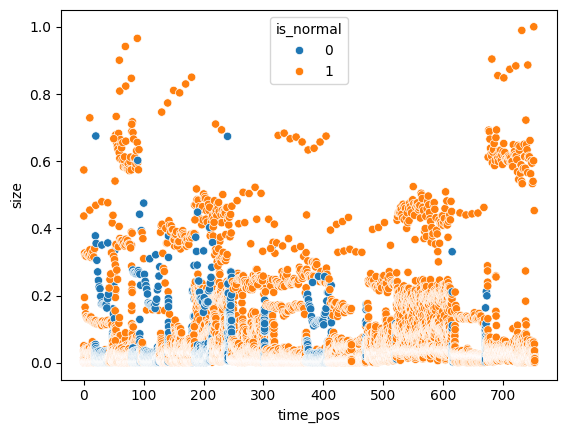

In [36]:
sns.scatterplot(x="time_pos",y="size",data=df_train.iloc[:25*1200],hue="is_normal")

In [37]:
plt.plot(

SyntaxError: incomplete input (582913220.py, line 1)

In [ ]:
sns.scatterplot(x="size",y="type",data=df_train,hue="is_normal")

In [119]:
model.save('fin_model.h5')

C:\ml\my_env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
